# Perform analysis and plots shown in paper

- I am using the conda environment version 22.04 http://climate-cms.wikis.unsw.edu.au/Conda#22.04
- The plots (and some extra analysis) are provided in order 

In [1]:
cd /home/563/slf563/code/gadi/jk72/ACCESS-CM2_analysis/COSP_analysis/Machine_learning_paper

/home/563/slf563/code/gadi/jk72/ACCESS-CM2_analysis/COSP_analysis/Machine_learning_paper


In [2]:
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import seaborn as sns
import xarray as xr
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 12})
import time
from matplotlib.colors import LogNorm
from functions import * 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import cmocean
import shap
import pickle

In [3]:
sns.set_theme(color_codes=True)
sns.set_theme(style="whitegrid")

***
# Read in data and define some functions

In [4]:
obs = xr.open_dataset('/g/data/jk72/slf563/ACCESS/ML_data/COSP_vars_MODIS_2015-2019.nc')
mod = xr.open_dataset('/g/data/jk72/slf563/ACCESS/ML_data/COSP_vars_bx400_2015-2019.nc')
modi = xr.open_dataset('/g/data/jk72/slf563/ACCESS/ML_data/COSP_vars_cg207_2015-2019.nc')

In [5]:
lsmask = xr.open_dataset('/g/data/jk72/slf563/ACCESS/fx/sftlf_fx_ACCESS-CM2_amip_r1i1p1f1_gn.nc')
lsmask = ((lsmask.sftlf/100)-1)*-1
lsmask=lsmask.where(lsmask>0.5,np.nan)
lsmask=lsmask.where(np.isnan(lsmask),1)

In [6]:
sea_index = mod.groupby('time.season').groups

In [7]:
# Remove all land points, remove non-summer values and values outside region of interest
obs = (obs*lsmask).isel(time=sea_index['DJF']).sel(lat=slice(-69,-30)).transpose('time','lat','lon')
mod= (mod*lsmask).isel(time=sea_index['DJF']).sel(lat=slice(-69,-30)).transpose('time','lat','lon')
modi= (modi*lsmask).isel(time=sea_index['DJF']).sel(lat=slice(-69,-30)).transpose('time','lat','lon')

biases = (mod-obs)
biasesi = (modi-obs)

In [8]:
jobname = 'bx400'
pred = xr.open_dataset('/g/data/jk72/slf563/ACCESS/ML_data/XGBoost_predicted_SWCRE_2015-2019_{}2.nc'.format(jobname))
shap_vals = xr.open_dataset('/g/data/jk72/slf563/ACCESS/ML_data/SHAP_values_SWCRE_2015-2019_{}2.nc'.format(jobname))
pred = pred.transpose('time','lat','lon').rename({'SWCREtoa':'Predicted bias'})
shap_vals = shap_vals.transpose('time','lat','lon')
true = biases[['SWCREtoa']].rename({'SWCREtoa':'True bias'})
true = true.where(np.isfinite(pred['Predicted bias'])==True,np.nan) # make sure we are only comparing the same data points

In [9]:
jobname2 = 'cg207'
predi = xr.open_dataset('/g/data/jk72/slf563/ACCESS/ML_data/XGBoost_predicted_SWCRE_2015-2019_{}2.nc'.format(jobname2))
shap_valsi = xr.open_dataset('/g/data/jk72/slf563/ACCESS/ML_data/SHAP_values_SWCRE_2015-2019_{}2.nc'.format(jobname2))
predi = predi.transpose('time','lat','lon').rename({'SWCREtoa':'Predicted bias'})
shap_valsi = shap_valsi.transpose('time','lat','lon')

truei = biasesi[['SWCREtoa']].rename({'SWCREtoa':'True bias'})
truei = truei.where(np.isfinite(predi['Predicted bias'])==True,np.nan) # make sure we are only comparing the same data points

In [10]:
# Read in clusters from previous work
M10 = xr.open_dataset('/g/data/jk72/slf563/ACCESS/clustering_data/modis_cluster_labels_condensed_2015-2019.nc')
order_for_plotting = [6,2,4,5,8,1,0,3,7,9] 
names = np.array(M10['Cluster'].attrs['Cluster Short Names']).copy()[order_for_plotting]

In [11]:
def plot_biases(data,label,subplot,vmin,vmax,cmap='RdBu_r',norm='Norm',line='yes',cbar=False):
    if norm == 'Norm':
        norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
    if isinstance(subplot,int):
        ax = plt.subplot(subplot, projection=ccrs.Orthographic(140, -90))
    elif isinstance(subplot,list):
        ax = plt.subplot(subplot[0],subplot[1],subplot[2], projection=ccrs.Orthographic(140, -90))
    else: 
        ax = subplot 
    p = data.plot(
                cmap=cmap,
                transform=ccrs.PlateCarree(),
                ax = ax,
                norm=norm,
                add_colorbar=False,
                );
    ax.coastlines();
    plt.title('')
    plt.title(label,loc='left')
    
    if line=='yes':
        plot_line()
        
    if cbar==True: 
        plt.colorbar(p,orientation='horizontal',pad=0.05)
    return p

In [12]:
def plot_line(col='black'):
    ln = np.arange(0,360,1)
    lt = np.zeros(360)
    lt[:] = -69
    plt.plot(ln, lt,
         color=col, linewidth=1,linestyle='--',
         transform=ccrs.PlateCarree(),)
    
    lt[:] = -43
    plt.plot(ln, lt,
         color=col, linewidth=1,linestyle='--',
         transform=ccrs.PlateCarree(),)
    
    lt[:] = -58
    plt.plot(ln, lt,
         color=col, linewidth=1,linestyle='--',
         transform=ccrs.PlateCarree(),)
    
    lt[:] = -30
    plt.plot(ln, lt,
         color=col, linewidth=1,linestyle='--',
         transform=ccrs.PlateCarree(),)
    

*** 
# Figure 1 (+ Appendix Figure 1)

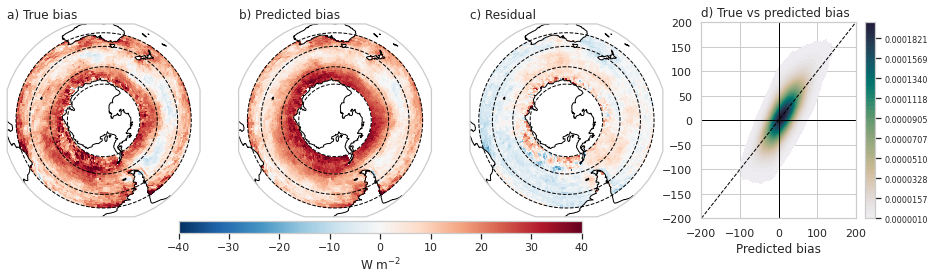

In [13]:
data = xr.merge([pred['Predicted bias'],true['True bias']]).to_dataframe()
data = data.dropna()

fig = plt.figure(figsize=(14,4))

ax = plt.subplot(144)
cmap = 'black' 

#p = plt.scatter(data=data,x='Predicted bias',y='True bias',
#                s=0.5,alpha=0.5,color=cmap)

p = sns.kdeplot(data=data,x='Predicted bias',y='True bias',
                fill=True,cbar=True,thresh=0.01, levels=50,cmap=cmocean.cm.rain,alpha=1,
                )

plt.axline((0,0),slope=1,c='black',linewidth=1,linestyle='--')
plt.axhline(0,c='black',linewidth=1)
plt.axvline(0,c='black',linewidth=1)
plt.title('d) True vs predicted bias',loc='left')
plt.ylim(-200,200)
plt.xlim(-200,200)

cax = p.figure.axes[-1]
ticks = cax.get_xticks()
cax.set_xticks(ticks[::3])
cax.set_xticklabels(np.round(ticks*1e4,2)[::3]);
cax.tick_params(labelsize=8)

p2 = plot_biases(true['True bias'].mean('time'),'a) True bias',141,-40,40)

p2 = plot_biases(pred['Predicted bias'].mean('time'),'b) Predicted bias',142,-40,40)

residual = pred['Predicted bias'] - true['True bias']
p2 = plot_biases(residual.mean('time'),'c) Residual',143,-40,40)

cax = plt.axes([0.2, 0.15, 0.4, 0.04])
plt.colorbar(p2,cax=cax,label='W m$^{-2}$',orientation='horizontal');
plt.subplots_adjust(bottom=0.2,right=0.91,left=0.03)

#plt.savefig('plots/XGBoost_summary.png',dpi=300,bbox_inches='tight')

### Some other stats

In [14]:
def calc_stats(lat1=-69,lat2=-30):
    data = xr.merge([pred['Predicted bias'],true['True bias']]).sel(lat=slice(lat1,lat2)).to_dataframe().dropna()
    print('Mean')
    print(data.mean())
    print('Median')
    print(data.median())
    print('Std')
    print(data.std())

In [15]:
calc_stats(lat1=-69,lat2=-30)

Mean
Predicted bias    12.427678
True bias         12.428512
dtype: float32
Median
Predicted bias    11.376080
True bias         11.694408
dtype: float32
Std
Predicted bias    32.854118
True bias         44.385780
dtype: float32


In [16]:
calc_stats(lat1=-69,lat2=-58)

Mean
Predicted bias    24.051868
True bias         20.475214
dtype: float32
Median
Predicted bias    23.212341
True bias         19.379498
dtype: float32
Std
Predicted bias    27.315916
True bias         39.067982
dtype: float32


In [17]:
calc_stats(lat1=-58,lat2=-43)

Mean
Predicted bias    8.171968
True bias         8.147409
dtype: float32
Median
Predicted bias    6.893631
True bias         7.331726
dtype: float32
Std
Predicted bias    30.553545
True bias         42.505871
dtype: float32


In [18]:
calc_stats(lat1=-43,lat2=-30)

Mean
Predicted bias    10.759406
True bias         13.731440
dtype: float32
Median
Predicted bias     8.565102
True bias         12.654228
dtype: float32
Std
Predicted bias    38.407452
True bias         50.476509
dtype: float32


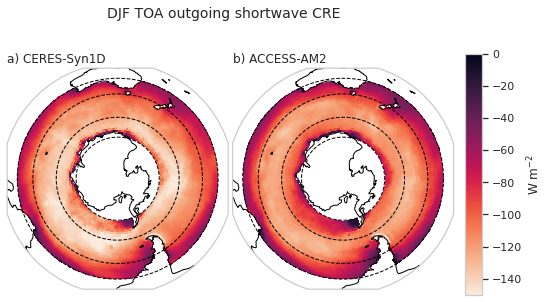

In [19]:
# Appendix Figure 1
fig = plt.figure(figsize=(8,5))
p1 = plot_biases((obs.SWCREtoa).mean('time'),'a) CERES-Syn1D',121,-150,0,
                cmap=sns.color_palette("rocket_r", as_cmap=True))
p1 = plot_biases((mod.SWCREtoa).mean('time'),'b) ACCESS-AM2',122,-150,0,
                cmap=sns.color_palette("rocket_r", as_cmap=True))
#p2 = plot_biases(biases.SWCREtoa.mean('time'),'c) ACCESS - CERES',144,-40,40)

cax = plt.axes([0.92, 0.18, 0.03, 0.67])
plt.colorbar(p1,cax=cax,label='W m$^{-2}$');

#cax = plt.axes([0.63, 0.22, 0.02, 0.6])
#plt.colorbar(p2,cax=cax,label='W m$^{-2}$');

plt.subplots_adjust(right=0.9,wspace=0.02)
plt.suptitle('DJF TOA outgoing shortwave CRE',size=14);
plt.savefig('plots/TOA_SWCRE_biases.pdf')

********
# Multi-linear regression & correlation analysis (+ Appendix Figure 2)
- Test how well a simple MLR performs in predicting the SWCRE bias. 
- Also work out how well each predictor is linearly related to the SWCRE bias and to each other

In [20]:
data = biases.drop(labels = ['SWtoa'])
predictors= list(data.drop_vars(['SWCREtoa']).keys())
target = 'SWCREtoa'
year_index = data.groupby('time.year').groups

for test_year in [2016,2017,2018]:

    yr = np.array(year_index[test_year][:])-31
    test = data.isel(time=yr).to_dataframe().dropna()
    train = data.drop_isel(time=yr).to_dataframe().dropna()


    regr = linear_model.LinearRegression()
    model = regr.fit(train[predictors], train[target])
    mlr_pred = regr.predict(test[predictors])

    print('Test year:', test_year)
    print('RMSE:', mean_squared_error(test[target], mlr_pred)**(1/2))
    print('R2:', r2_score(test[target], mlr_pred))
    print('  ')

Test year: 2016
RMSE: 33.97595946356902
R2: 0.41840538174663455
  
Test year: 2017
RMSE: 33.27802247136148
R2: 0.43518889434380237
  
Test year: 2018
RMSE: 33.42556130568655
R2: 0.4260589500826607
  


In [21]:
labels = ['LWP','IWP','CFL','CFI','TauL','TauI','CTP']
cor = pd.DataFrame(np.zeros((4,7)),index=['Polar','Sub-polar','Mid-lats','SO'],columns=labels)
for fld in labels:
    cor[fld]['Polar'] = (xr.corr(biases.SWCREtoa.sel(lat=slice(-69,-59)),
                               biases[fld].sel(lat=slice(-69,-59))).values)**2
    cor[fld]['Sub-polar'] = (xr.corr(biases.SWCREtoa.sel(lat=slice(-59,-43)),
                               biases[fld].sel(lat=slice(-59,-43))).values)**2
    cor[fld]['Mid-lats'] = (xr.corr(biases.SWCREtoa.sel(lat=slice(-43,-30)),
                               biases[fld].sel(lat=slice(-43,-30))).values)**2    
    cor[fld]['SO'] = (xr.corr(biases.SWCREtoa.sel(lat=slice(-69,-30)),
                               biases[fld].sel(lat=slice(-69,-30))).values)**2

In [22]:
cor

,LWP,IWP,CFL,CFI,TauL,TauI,CTP
Polar,0.219920,0.080816,0.210702,0.014068,0.040373,0.103571,0.058135
Sub-polar,0.266811,0.066624,0.073088,0.027684,0.103168,0.106541,0.062637
Mid-lats,0.324115,0.139734,0.237138,0.117063,0.084029,0.100106,0.097706
SO,0.296647,0.075116,0.157709,0.012532,0.096852,0.106247,0.076596


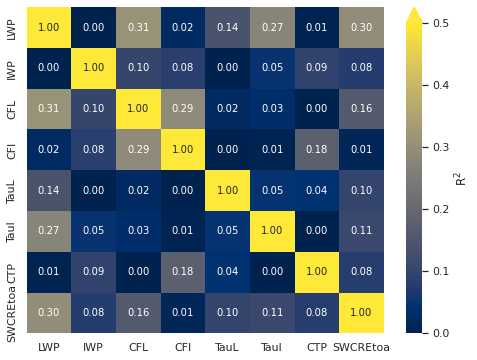

In [23]:
# Appendix Figure 2
data = biases.drop(labels = ['SWtoa']).to_dataframe()
fig = plt.figure(figsize=(8,6))
sns.heatmap((data.corr().abs()**2),annot=True,vmin=0, vmax=0.5,cmap='cividis',
            cbar_kws={'label':'R${^2}$','extend':'max'},fmt='.2f');
plt.savefig('plots/correlations.pdf')

***** 

# Figure 2

This will be combined with some of the SHAP summary figures in the run_XGBoost+SHAP notebook 

In [24]:
pred['Predicted bias'].mean()

<xarray.DataArray 'Predicted bias' ()>
array(12.42775, dtype=float32)

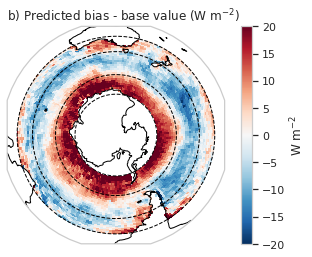

In [25]:
p2 = plot_biases(pred['Predicted bias'].mean('time')-pred['Predicted bias'].mean(),
                 'b) Predicted bias - base value (W m$^{-2}$)',111,-20,20)
plt.colorbar(p2,label='W m$^{-2}$');
plt.savefig('plots/SHAP_total.pdf',bbox_inches = 'tight')

**** 

# Figure 3

In [26]:
shappd = shap_vals.to_dataframe(dim_order=['time','lat','lon'])
biasesd = biases.to_dataframe(dim_order=['time','lat','lon'])

In [27]:
def plot_scatter(fld,unit,abc,ax):
    
    x = biasesd[fld]
    y = shappd[fld]
    
    col = 'black' #sns.color_palette("crest",20)
    
    #p = plt.scatter(x=x,y=y,s=0.5,alpha=0.5,
    #           color=col)
                    
    kdeplot = sns.kdeplot(x=x, y=y,ax=ax,
                    fill=True,cbar=True,thresh=0.0001, levels=50,cmap=cmocean.cm.rain,alpha=0.8,
                    cbar_kws=({'orientation':'horizontal','pad':0.3,'label':'Density (x 1e-4)'}))

    plt.axhline(0,c='black',linewidth=1)
    plt.axvline(0,c='black',linewidth=1)
    plt.ylabel('')
    plt.xlabel('{} bias ({})'.format(fld,unit))
    plt.title(abc+') '+fld,loc='left')
    ax.tick_params(axis='y', which='major', pad=-5)
    ax.tick_params(axis='x', which='major', pad=0)
    
    cax = kdeplot.figure.axes[-1]
    ticks = cax.get_xticks()
    cax.set_xticks(ticks[::3])
    cax.set_xticklabels(np.round(ticks*1e4,2)[::3]);
    cax.tick_params(labelsize=8)
    
    return

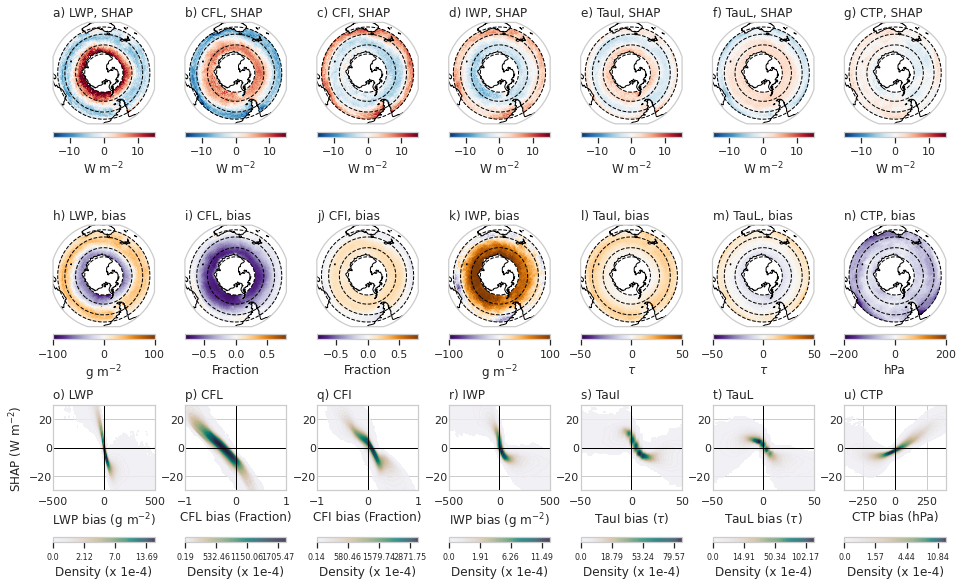

In [28]:
fig = plt.figure(figsize=(16,10))
cm1 = sns.cubehelix_palette(start=0.7, rot=-1, as_cmap=True)
cm2 = 'PuOr_r' #cmocean.cm.delta #  sns.diverging_palette(220, 20, as_cmap=True)
cm3 = 'RdBu_r'

labels = ['LWP','CFL','CFI','IWP','TauI','TauL','CTP']
units = ['g m$^{-2}$','Fraction','Fraction','g m$^{-2}$','${\\tau}$','${\\tau}$','hPa']
xlim = [[-500,500],[-1,1],[-1,1],[-500,500],[-50,50],[-50,50],[-400,400]]


abc = ['o','p','q','r','s','t','u']
for i,fld in enumerate(labels):
    ax = plt.subplot(3,7,15+i)
    plot_scatter(fld,units[i],abc[i],ax)
    if i == 0: plt.ylabel('SHAP (W m$^{-2}$)')
    plt.ylim(-30,30)
    plt.xlim(xlim[i])
    
#********************************************************************************************   

p2 = plot_biases((biases['LWP']).mean('time'),'h) LWP, bias ',378,-100,100,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p2,orientation='horizontal',label='g m$^{-2}$',pad=0.05)
                 
p2 = plot_biases((biases['CFL']).mean('time'),'i) CFL, bias ',[3,7,9],-0.8,0.8,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p2,orientation='horizontal',label='Fraction',pad=0.05) 
                                            
p2 = plot_biases((biases['CFI']).mean('time'),'j) CFI, bias ',[3,7,10],-0.8,0.8,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p2,orientation='horizontal',label='Fraction',pad=0.05)

p2 = plot_biases((biases['IWP']).mean('time'),'k) IWP, bias ',[3,7,11],-100,100,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p2,orientation='horizontal',label='g m$^{-2}$',pad=0.05)                   

p2 = plot_biases((biases['TauI']).mean('time'),'l) TauI, bias ',[3,7,12],-50,50,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p2,orientation='horizontal',label='${\\tau}$',pad=0.05)

p2 = plot_biases((biases['TauL']).mean('time'),'m) TauL, bias ',[3,7,13],-50,50,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p2,orientation='horizontal',label='${\\tau}$',pad=0.05)

p2 = plot_biases((biases['CTP']).mean('time'),'n) CTP, bias ',[3,7,14],-200,200,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p2,orientation='horizontal',label='hPa',pad=0.05)

#********************************************************************************************
p3 = plot_biases(shap_vals['LWP'].mean('time'),'a) LWP, SHAP',[3,7,1],-15,15,
                cmap=cm3,cbar=False)
cbar = plt.colorbar(p3,orientation='horizontal',label='W m$^{-2}$',pad=0.05)
                 
p3 = plot_biases(shap_vals['CFL'].mean('time'),'b) CFL, SHAP',[3,7,2],-15,15,
                cmap=cm3,cbar=False)
cbar = plt.colorbar(p3,orientation='horizontal',label='W m$^{-2}$',pad=0.05)
                 
p3 = plot_biases(shap_vals['CFI'].mean('time'),'c) CFI, SHAP',[3,7,3],-15,15,
                cmap=cm3,cbar=False)
cbar = plt.colorbar(p3,orientation='horizontal',label='W m$^{-2}$',pad=0.05)

p3 = plot_biases(shap_vals['IWP'].mean('time'),'d) IWP, SHAP',[3,7,4],-15,15,
                cmap=cm3,cbar=False)
cbar = plt.colorbar(p3,orientation='horizontal',label='W m$^{-2}$',pad=0.05)
                 
p3 = plot_biases(shap_vals['TauI'].mean('time'),'e) TauI, SHAP',[3,7,5],-15,15,
                cmap=cm3,cbar=False)
cbar = plt.colorbar(p3,orientation='horizontal',label='W m$^{-2}$',pad=0.05)

p3 = plot_biases(shap_vals['TauL'].mean('time'),'f) TauL, SHAP',[3,7,6],-15,15,
                cmap=cm3,cbar=False)
cbar = plt.colorbar(p3,orientation='horizontal',label='W m$^{-2}$',pad=0.05)

p3 = plot_biases(shap_vals['CTP'].mean('time'),'g) CTP, SHAP',[3,7,7],-15,15,
                cmap=cm3,cbar=False)
cbar = plt.colorbar(p3,orientation='horizontal',label='W m$^{-2}$',pad=0.05)

plt.subplots_adjust(hspace=0.3,wspace=0.3,bottom=0.1)

plt.savefig('plots/COSP_mean_biases_SHAP_v2.png',dpi=300,bbox_inches='tight')

**** 

# Figure 4

In [29]:
cluster_biasesc_m = pd.DataFrame(columns=list(shap_vals.keys()),index=names)
cluster_shapc_m = pd.DataFrame(columns=list(shap_vals.keys()),index=names)

cluster_biasesc_s = pd.DataFrame(columns=list(shap_vals.keys()),index=names)
cluster_shapc_s = pd.DataFrame(columns=list(shap_vals.keys()),index=names)

cluster_biasesc_p = pd.DataFrame(columns=list(shap_vals.keys()),index=names)
cluster_shapc_p = pd.DataFrame(columns=list(shap_vals.keys()),index=names)

count_m = pd.DataFrame(columns=['Count'],index=names)
count_s = pd.DataFrame(columns=['Count'],index=names)
count_p = pd.DataFrame(columns=['Count'],index=names)

for i,c in enumerate(order_for_plotting): 

    k = M10.isel(time=sea_index['DJF']).sel(lat=slice(-43,-30)).where(M10==c)
    if c > 0: k.Cluster[:] = k.Cluster[:]/k.Cluster[:]
    if c == 0: k.Cluster[:] = k.Cluster[:]+1
    
    count_m.iloc[i]['Count'] = float(k.Cluster.sum())
    cluster_biasesc_m.iloc[i] = ((biases).sel(lat=slice(-43,-30))*k.Cluster).mean().drop(['SWtoa','SWCREtoa']).to_pandas()
    cluster_shapc_m.iloc[i] = ((shap_vals).sel(lat=slice(-43,-30))*k.Cluster).mean().to_pandas()
    
    
    k = M10.isel(time=sea_index['DJF']).sel(lat=slice(-59,-43)).where(M10==c)
    if c > 0: k.Cluster[:] = k.Cluster[:]/k.Cluster[:]
    if c == 0: k.Cluster[:] = k.Cluster[:]+1
    
    count_s.iloc[i]['Count'] = float(k.Cluster.sum())
    cluster_biasesc_s.iloc[i] = ((biases).sel(lat=slice(-59,-43))*k.Cluster).mean().drop(['SWtoa','SWCREtoa']).to_pandas()
    cluster_shapc_s.iloc[i] = ((shap_vals).sel(lat=slice(-59,-43))*k.Cluster).mean().to_pandas()
    
    
    k = M10.isel(time=sea_index['DJF']).sel(lat=slice(-69,-59)).where(M10==c)
    if c > 0: k.Cluster[:] = k.Cluster[:]/k.Cluster[:]
    if c == 0: k.Cluster[:] = k.Cluster[:]+1
    
    count_p.iloc[i]['Count'] = float(k.Cluster.sum())
    cluster_biasesc_p.iloc[i] = ((biases).sel(lat=slice(-69,-59))*k.Cluster).mean().drop(['SWtoa','SWCREtoa']).to_pandas()
    cluster_shapc_p.iloc[i] = ((shap_vals).sel(lat=slice(-69,-59))*k.Cluster).mean().to_pandas()

In [30]:
def scatter_clusters(fld,abc,unit,change='yes'):
    
    plt.axhline(0,color='black',linewidth=0.5)
    plt.axvline(0,color='black',linewidth=0.5)
        
    plt.scatter(x=cluster_biasesc_m[fld].iloc[3],y=100,
                    color='white',edgecolor='grey',s=50,
                    marker='^',label='Mid-latitudes',alpha=0.5)
    
    p = plt.scatter(x=cluster_biasesc_m[fld].iloc[0:10],y=cluster_shapc_m[fld].iloc[0:10],
                    c=np.arange(0,10),cmap=truncate_colormap(sns.color_palette("cubehelix",as_cmap=True),0.2,0.9),
                    edgecolor='black',s=list((count_m['Count'].iloc[0:10]/1000)),marker='^',alpha=0.7)
    
    
        
    plt.scatter(x=cluster_biasesc_s[fld].iloc[3],y=100,
                    color='white',edgecolor='grey',s=50,
                    marker='s',label='Sub-polar',alpha=0.5)
    
    p = plt.scatter(x=cluster_biasesc_s[fld].iloc[0:10],y=cluster_shapc_s[fld].iloc[0:10],
                    c=np.arange(0,10),cmap=truncate_colormap(sns.color_palette("cubehelix",as_cmap=True),0.2,0.9),
                    edgecolor='black',s=list((count_s['Count'].iloc[0:10]/1000)),marker='s',alpha=0.7)
    
        
    plt.scatter(x=cluster_biasesc_p[fld].iloc[3],y=100,
                    color='white',edgecolor='grey',s=50,
                    marker='v',label='Polar',alpha=0.5)
    
    p = plt.scatter(x=cluster_biasesc_p[fld].iloc[0:10],y=cluster_shapc_p[fld].iloc[0:10],
                    c=np.arange(0,10),cmap=truncate_colormap(sns.color_palette("cubehelix",as_cmap=True),0.2,0.9),
                    edgecolor='black',s=list((count_p['Count'].iloc[0:10]/1000)),marker='v',alpha=0.7)


    if change=='yes': plt.xlabel('\u0394{} ({})'.format(fld,unit));
    else: plt.xlabel('{} Bias ({})'.format(fld,unit));
    plt.ylabel('');
    plt.title('{}) {}'.format(abc,fld),loc='left');
    ax.tick_params(axis='y', which='major', pad=-5)
        
    return p

FixedFormatter should only be used together with FixedLocator


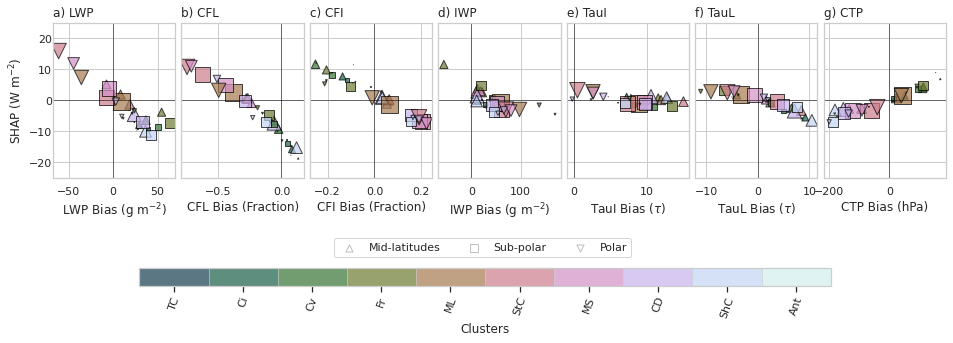

In [31]:
fig = plt.figure(figsize=(16,5))

labels = ['LWP','CFL','CFI','IWP','TauI','TauL','CTP']
alpha=['a','b','c','d','e','f','g']
units = ['g m$^{-2}$','Fraction','Fraction','g m$^{-2}$','${\\tau}$','${\\tau}$','hPa']
#xlim = [[-200,400],[-1,1],[-1,1],[-200,400],[-25,25],[-25,25],[-400,400]]

for i,fld in enumerate(labels):
    ax = plt.subplot(171+i)
    p = scatter_clusters(fld,alpha[i],units[i],change='no')
    if i == 0: plt.ylabel('SHAP (W m$^{-2}$)')
    if i > 0: ax.set_yticklabels([''])
    plt.ylim(-25,25)
    #plt.xlim(xlim[i])
    
plt.legend(ncol=5,loc='lower left',bbox_to_anchor=(-4.05, -0.55, 1, 1))

cax = plt.axes([0.2, 0.15, 0.6, 0.05])
cbar = plt.colorbar(p,cax=cax,orientation='horizontal',
             label='Clusters',ticks=np.arange(0,10),drawedges=True,boundaries=np.arange(-0.5,10.5));
cbar.ax.set_xticklabels(names[0:10],rotation=70);

plt.subplots_adjust(bottom=0.45,wspace=0.05)
plt.savefig('plots/SHAP+bias_control+clusters.pdf',bbox_inches='tight')

****

# Stats for ice run (and figure for appendix?)

In [32]:
# change in true vs predicted radiative biases... 

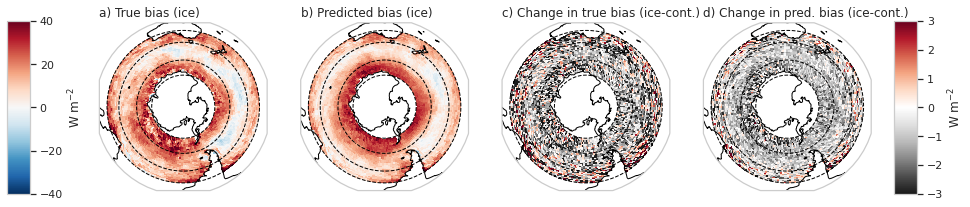

In [33]:
fig = plt.figure(figsize=(16,4))

p1 = plot_biases(truei['True bias'].mean('time'),'a) True bias (ice)',141,-40,40)

p1 = plot_biases(predi['Predicted bias'].mean('time'),'b) Predicted bias (ice)',142,-40,40)

p2 = plot_biases((truei['True bias']-true['True bias']).mean('time'),'c) Change in true bias (ice-cont.)',143,-3,3,cmap='RdGy_r')

p2 = plot_biases((predi['Predicted bias']-pred['Predicted bias']).mean('time'),'d) Change in pred. bias (ice-cont.)',144,-3,3,cmap='RdGy_r')

cax = plt.axes([0.05, 0.2, 0.02, 0.6])
plt.colorbar(p1,cax=cax,label='W m$^{-2}$',orientation='vertical');

cax = plt.axes([0.82, 0.2, 0.02, 0.6])
plt.colorbar(p2,cax=cax,label='W m$^{-2}$',orientation='vertical');

plt.subplots_adjust(right=0.8,left=0.13)

plt.savefig('plots/XGBoost_summary_ice.png',dpi=300,bbox_inches='tight')

In [34]:
print('SO: ',(truei['True bias']-true['True bias']).mean().values)
print('Pol: ',(truei['True bias']-true['True bias']).sel(lat=slice(-69,-59)).mean().values)
print('Sub: ',(truei['True bias']-true['True bias']).sel(lat=slice(-59,-43)).mean().values)
print('Mid: ',(truei['True bias']-true['True bias']).sel(lat=slice(-43,-30)).mean().values)
print('Varma: ',(truei['True bias']-true['True bias']).sel(lat=slice(-70,-50)).mean().values)

SO:  -1.0194
Pol:  -1.2347713
Sub:  -1.0681976
Mid:  -0.79198307
Varma:  -1.1849874


In [35]:
(predi['Predicted bias']-pred['Predicted bias']).mean()

<xarray.DataArray 'Predicted bias' ()>
array(-0.9361887, dtype=float32)

*******
# Figure 5

In [36]:
cluster_biases_m = pd.DataFrame(columns=list(shap_vals.keys()),index=names)
cluster_shap_m = pd.DataFrame(columns=list(shap_vals.keys()),index=names)

cluster_biases_s = pd.DataFrame(columns=list(shap_vals.keys()),index=names)
cluster_shap_s = pd.DataFrame(columns=list(shap_vals.keys()),index=names)

cluster_biases_p = pd.DataFrame(columns=list(shap_vals.keys()),index=names)
cluster_shap_p = pd.DataFrame(columns=list(shap_vals.keys()),index=names)

count_m = pd.DataFrame(columns=['Count'],index=names)
count_s = pd.DataFrame(columns=['Count'],index=names)
count_p = pd.DataFrame(columns=['Count'],index=names)

for i,c in enumerate(order_for_plotting): 

    k = M10.isel(time=sea_index['DJF']).sel(lat=slice(-43,-30)).where(M10==c)
    if c > 0: k.Cluster[:] = k.Cluster[:]/k.Cluster[:]
    if c == 0: k.Cluster[:] = k.Cluster[:]+1
    
    count_m.iloc[i]['Count'] = float(k.Cluster.sum())
    cluster_biases_m.iloc[i] = ((modi-mod).sel(lat=slice(-43,-30))*k.Cluster).mean().drop(['SWtoa','SWCREtoa']).to_pandas()
    cluster_shap_m.iloc[i] = ((shap_valsi-shap_vals).sel(lat=slice(-43,-30))*k.Cluster).mean().to_pandas()
    
    
    k = M10.isel(time=sea_index['DJF']).sel(lat=slice(-59,-43)).where(M10==c)
    if c > 0: k.Cluster[:] = k.Cluster[:]/k.Cluster[:]
    if c == 0: k.Cluster[:] = k.Cluster[:]+1
    
    count_s.iloc[i]['Count'] = float(k.Cluster.sum())
    cluster_biases_s.iloc[i] = ((modi-mod).sel(lat=slice(-59,-43))*k.Cluster).mean().drop(['SWtoa','SWCREtoa']).to_pandas()
    cluster_shap_s.iloc[i] = ((shap_valsi-shap_vals).sel(lat=slice(-59,-43))*k.Cluster).mean().to_pandas()
    
    
    k = M10.isel(time=sea_index['DJF']).sel(lat=slice(-69,-59)).where(M10==c)
    if c > 0: k.Cluster[:] = k.Cluster[:]/k.Cluster[:]
    if c == 0: k.Cluster[:] = k.Cluster[:]+1
    
    count_p.iloc[i]['Count'] = float(k.Cluster.sum())
    cluster_biases_p.iloc[i] = ((modi-mod).sel(lat=slice(-69,-59))*k.Cluster).mean().drop(['SWtoa','SWCREtoa']).to_pandas()
    cluster_shap_p.iloc[i] = ((shap_valsi-shap_vals).sel(lat=slice(-69,-59))*k.Cluster).mean().to_pandas()

In [37]:
def scatter_cluster_changes(fld,abc,unit,change='yes'):
    
    plt.axhline(0,color='black',linewidth=0.5)
    plt.axvline(0,color='black',linewidth=0.5)
        
    plt.scatter(x=cluster_biases_m[fld].iloc[3],y=9,
                    color='white',edgecolor='grey',s=50,
                    marker='^',label='Mid-latitudes',alpha=0.5)
    
    p = plt.scatter(x=cluster_biases_m[fld].iloc[0:10],y=cluster_shap_m[fld].iloc[0:10],
                    c=np.arange(0,10),cmap=truncate_colormap(sns.color_palette("cubehelix",as_cmap=True),0.2,0.9),
                    edgecolor='black',s=list((count_m['Count'].iloc[0:10]/1000)),marker='^',alpha=0.7)
    
    
        
    plt.scatter(x=cluster_biases_s[fld].iloc[3],y=9,
                    color='white',edgecolor='grey',s=50,
                    marker='s',label='Sub-polar',alpha=0.5)
    
    p = plt.scatter(x=cluster_biases_s[fld].iloc[0:10],y=cluster_shap_s[fld].iloc[0:10],
                    c=np.arange(0,10),cmap=truncate_colormap(sns.color_palette("cubehelix",as_cmap=True),0.2,0.9),
                    edgecolor='black',s=list((count_s['Count'].iloc[0:10]/1000)),marker='s',alpha=0.7)
    
        
    plt.scatter(x=cluster_biases_p[fld].iloc[6],y=9,
                    color='white',edgecolor='grey',s=50,
                    marker='v',label='Polar',alpha=0.5)
    
    p = plt.scatter(x=cluster_biases_p[fld].iloc[0:10],y=cluster_shap_p[fld].iloc[0:10],
                    c=np.arange(0,10),cmap=truncate_colormap(sns.color_palette("cubehelix",as_cmap=True),0.2,0.9),
                    edgecolor='black',s=list((count_p['Count'].iloc[0:10]/1000)),marker='v',alpha=0.7)


    if change=='yes': plt.xlabel('\u0394{} ({})'.format(fld,unit));
    else: plt.xlabel('{} Bias ({})'.format(fld,unit));
    plt.ylabel('');
    plt.title('{}) {}'.format(abc,fld),loc='left');
    ax.tick_params(axis='y', which='major', pad=-5)
        
    return p


FixedFormatter should only be used together with FixedLocator


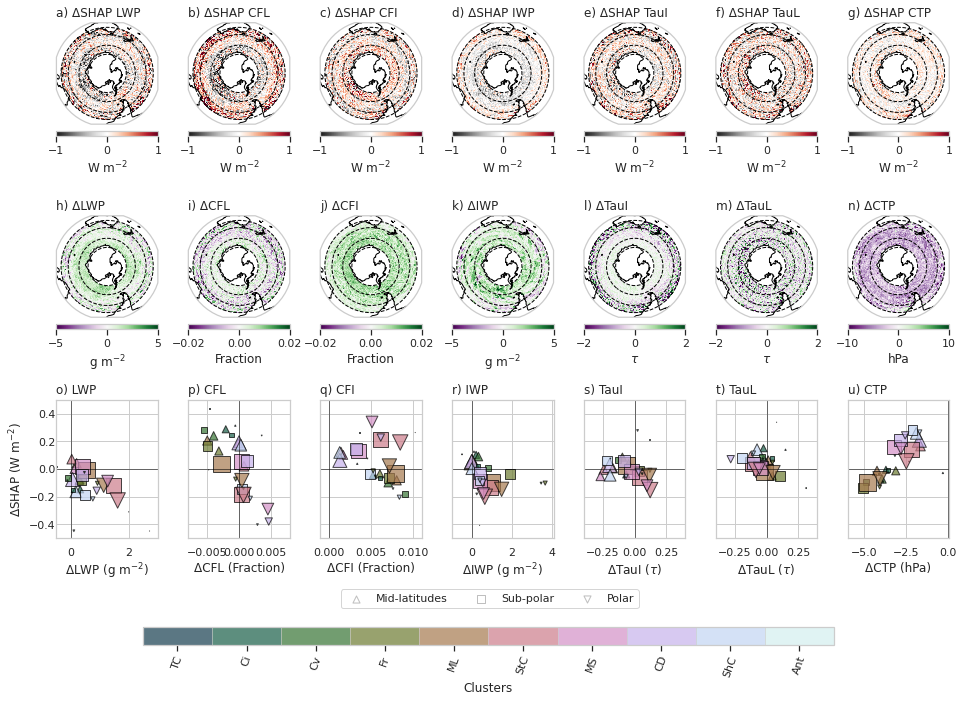

In [38]:
fig = plt.figure(figsize=(16,12))
cm1 = 'RdGy_r'
cm2 = 'PRGn' #cmocean.cm.delta #  sns.diverging_palette(220, 20, as_cmap=True)


p1 = plot_biases((shap_valsi['LWP']-shap_vals['LWP']).mean('time'),'a) \u0394SHAP LWP',[4,7,1],-1,1,
                cmap=cm1,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='W m$^{-2}$',pad=0.05)

p1 = plot_biases((shap_valsi['CFL']-shap_vals['CFL']).mean('time'),'b) \u0394SHAP CFL',[4,7,2],-1,1,
                cmap=cm1,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='W m$^{-2}$',pad=0.05)

p1 = plot_biases((shap_valsi['CFI']-shap_vals['CFI']).mean('time'),'c) \u0394SHAP CFI',[4,7,3],-1,1,
                cmap=cm1,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='W m$^{-2}$',pad=0.05)

p1 = plot_biases((shap_valsi['IWP']-shap_vals['IWP']).mean('time'),'d) \u0394SHAP IWP',[4,7,4],-1,1,
                cmap=cm1,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='W m$^{-2}$',pad=0.05)

p1 = plot_biases((shap_valsi['TauI']-shap_vals['TauI']).mean('time'),'e) \u0394SHAP TauI',[4,7,5],-1,1,
                cmap=cm1,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='W m$^{-2}$',pad=0.05)

p1 = plot_biases((shap_valsi['TauL']-shap_vals['TauL']).mean('time'),'f) \u0394SHAP TauL',[4,7,6],-1,1,
                cmap=cm1,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='W m$^{-2}$',pad=0.05)

p1 = plot_biases((shap_valsi['CTP']-shap_vals['CTP']).mean('time'),'g) \u0394SHAP CTP',[4,7,7],-1,1,
                cmap=cm1,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='W m$^{-2}$',pad=0.05)

#********************************************************************************************   

p1 = plot_biases((biasesi['LWP']-biases['LWP']).mean('time'),'h) \u0394LWP',[4,7,8],-5,5,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='g m$^{-2}$',pad=0.05)

p1 = plot_biases((biasesi['CFL']-biases['CFL']).mean('time'),'i) \u0394CFL',[4,7,9],-0.02,0.02,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='Fraction',pad=0.05) 

p1 = plot_biases((biasesi['CFI']-biases['CFI']).mean('time'),'j) \u0394CFI',[4,7,10],-0.02,0.02,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='Fraction',pad=0.05) 

p1 = plot_biases((biasesi['IWP']-biases['IWP']).mean('time'),'k) \u0394IWP',[4,7,11],-5,5,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='g m$^{-2}$',pad=0.05)

p1 = plot_biases((biasesi['TauI']-biases['TauI']).mean('time'),'l) \u0394TauI',[4,7,12],-2,2,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='${\\tau}$',pad=0.05)

p1 = plot_biases((biasesi['TauL']-biases['TauL']).mean('time'),'m) \u0394TauL',[4,7,13],-2,2,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='${\\tau}$',pad=0.05)

p1 = plot_biases((biasesi['CTP']-biases['CTP']).mean('time'),'n) \u0394CTP',[4,7,14],-10,10,
                cmap=cm2,cbar=False)
cbar = plt.colorbar(p1,orientation='horizontal',label='hPa',pad=0.05)

#********************************************************************************************   

alpha=['o','p','q','r','s','t','u']
units = ['g m$^{-2}$','Fraction','Fraction','g m$^{-2}$','${\\tau}$','${\\tau}$','hPa']
xlims=[[-0.5,3],[-0.008,0.008],[-0.001,0.011],[-1,4.1],[-0.4,0.4],[-0.4,0.4],[-6,0.1]]

for i,fld in enumerate(labels):
    ax = plt.subplot(4,7,15+i)
    p = scatter_cluster_changes(fld,alpha[i],units[i],change='yes')
    if i == 0: plt.ylabel('\u0394SHAP (W m$^{-2}$)')
    if i > 0: ax.set_yticklabels([''])
    plt.ylim(-0.5,0.5)
    plt.xlim(xlims[i])
    
plt.legend(ncol=5,loc='lower left',bbox_to_anchor=(-5.05, -0.55, 1, 1))

cax = plt.axes([0.2, 0.15, 0.6, 0.02])
cbar = plt.colorbar(p,cax=cax,orientation='horizontal',
             label='Clusters',ticks=np.arange(0,10),drawedges=True,boundaries=np.arange(-0.5,10.5));
cbar.ax.set_xticklabels(names[0:10],rotation=70);

plt.subplots_adjust(hspace=0.4,wspace=0.3,bottom=0.05)
plt.savefig('plots/ice_SHAP_bias_diffs.png',dpi=300,bbox_inches='tight')

****

# Other plots used for analysis... 

### Sum the SHAP components of liquid/field based values

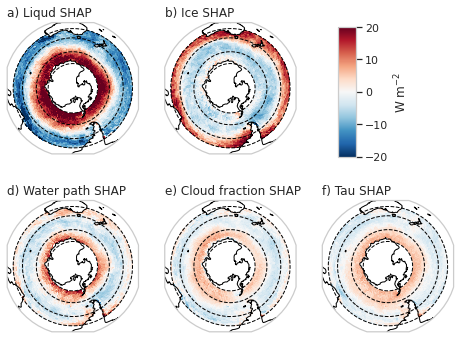

In [39]:
fig = plt.figure(figsize=(8,6))
cm1 = 'RdBu_r'

p3 = plot_biases((shap_vals['LWP']+shap_vals['CFL']+shap_vals['TauL']).mean('time'),'a) Liqud SHAP',[2,3,1],-20,20,
                cmap=cm1,cbar=False)

p3 = plot_biases((shap_vals['IWP']+shap_vals['CFI']+shap_vals['TauI']).mean('time'),'b) Ice SHAP',[2,3,2],-20,20,
                cmap=cm1,cbar=False)

#p3 = plot_biases((shap_vals['CTP']).mean('time').T,'c) CTP SHAP',[2,4,3],-20,20,
#                cmap=cm1,cbar=False)


p3 = plot_biases((shap_vals['LWP']+shap_vals['IWP']).mean('time'),'d) Water path SHAP',[2,3,4],-20,20,
                cmap=cm1,cbar=False)

p3 = plot_biases((shap_vals['CFL']+shap_vals['CFI']).mean('time'),'e) Cloud fraction SHAP',[2,3,5],-20,20,
                cmap=cm1,cbar=False)

p3 = plot_biases((shap_vals['TauL']+shap_vals['TauI']).mean('time'),'f) Tau SHAP',[2,3,6],-20,20,
                cmap=cm1,cbar=False)


#p2 = plot_biases(pred['Predicted bias'].mean('time')-pred['Predicted bias'].mean(),'g) Predicted bias - mean \n(-12.42 W m$^{-2}$)',144,-20,20)

cax = plt.axes([0.7, 0.55, 0.03, 0.3])
cbar = plt.colorbar(p3,cax=cax, orientation='vertical',label='W m$^{-2}$',pad=0.05)
plt.savefig('plots/SHAP_breakdowns.pdf')   

### Check how rainfall has changed between two simulations

In [40]:
prc = xr.open_dataset('/g/data/jk72/slf563/ACCESS/ML_data/precip_vars_bx400_2015-2019.nc')
pri = xr.open_dataset('/g/data/jk72/slf563/ACCESS/ML_data/precip_vars_cg207_2015-2019.nc')
prbias = (pri.isel(time=sea_index['DJF'])-prc.isel(time=sea_index['DJF']))

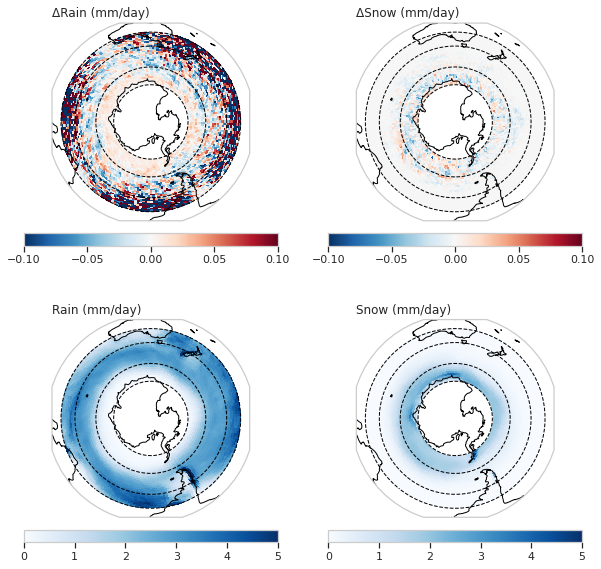

In [41]:
fig = plt.figure(figsize=(10,10))
p1 = plot_biases(prbias['rain'].sel(lat=slice(-69,-30)).mean('time'),'\u0394Rain (mm/day)',221,-0.1,0.1,
                cmap='RdBu_r',cbar=True)
p1 = plot_biases(prbias['snow'].sel(lat=slice(-69,-30)).mean('time'),'\u0394Snow (mm/day)',222,-0.1,0.1,
                cmap='RdBu_r',cbar=True)
p1 = plot_biases(prc['rain'].sel(lat=slice(-69,-30)).mean('time'),'Rain (mm/day)',223,0,5,
                cmap='Blues',cbar=True)
p1 = plot_biases(prc['snow'].sel(lat=slice(-69,-30)).mean('time'),'Snow (mm/day)',224,0,5,
                cmap='Blues',cbar=True)